# Malaria Cell Detection

This R-CNN model is trained to detect the location of malaria cells in images.

### Dependencies 

In [ ]:
pip install torch numpy matplotlib pandas tensorflow-macos tensorflow-datasets opencv-python pillow

### Imports

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display
from PIL import Image
import random

## Loading the Data

Getting the malaria dataset from the tensorflow library and loading it into a DataLoader from torch. 


In [6]:
# Getting the malaria dataset from the tensorflow library and loading it into a DataLoader from torch. 
malaria_ds = tfds.load(
    'malaria', 
    split=['train', 'validation'], 
    as_supervised=True, 
    with_info=True)
df = tfds.as_dataframe(malaria_ds[0], malaria_ds[1])
print(df.shape)

(27558, 2)


### Preview Samples

Have a look at the samples: 

In [7]:
def show_malaria_image(image, label): 
    plt.imshow(image, cmap='gray')
    plt.title("Uninfected" if label else "Infected", loc='center')
    plt.ylabel(f"Height ({image.shape[0]})")
    plt.xlabel(f"Width ({image.shape[1]})")
    plt.show()

In [8]:
def show_samples(samples):
    x = int(len(samples) / 2)
    y = len(samples) - x
    for i in range(len(samples)):
        plt.subplot(x, y, i + 1)
        plt.subplots_adjust(hspace=1)
        plt.imshow(samples[i][0], cmap='gray')
        plt.title("Uninfected" if samples[i][1] else "Infected", loc='center')
        plt.ylabel(f"Height ({samples[i][0].shape[0]})")
        plt.xlabel(f"Width ({samples[i][0].shape[1]})")
    plt.show()

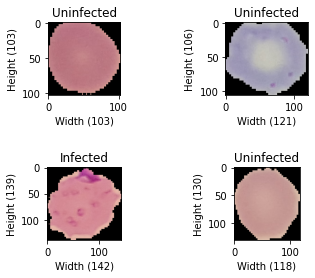

In [9]:
show_samples(df[:4].values)

### Exploring the Data

We now perform a quick exploration of the data.

Number of different shapes:  1627


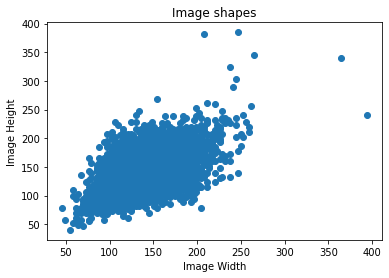

In [10]:
shapes = []
outliers = []
for image, label in zip(df["image"], df["label"]):
    if image.shape not in shapes: 
        shapes.append(image.shape)
    if image.shape[0] > 300 or image.shape[1] > 300:
        outliers.append((image, label))

print("Number of different shapes: ", len(shapes))

# create a scatter plot of the different shapes
plt.title("Image shapes")
plt.scatter(x=[shape[1] for shape in shapes],y=[shape[0] for shape in shapes])
plt.ylabel("Image Height")
plt.xlabel("Image Width")
plt.show()

In [ ]:
print(f"There are {len(outliers)} images with a width or height greater than 300")
outlier_shapes = np.array([img[0].shape for img in outliers])
table = pd.DataFrame(data=outlier_shapes[:,:2], columns=["Height", "Width"])
display(table)

index = int(input("Enter the number of the image to show: "))
assert index < len(outliers)
show_malaria_image(outliers[index][0], outliers[index][1])

## Data Augmentation

We will use the following transforms to augment the data:

* Resize the data for the model
* Random rotation and zoom
* Width and height 
* Shear intensity
* Horizontal flip

### Resizing the Images

We can use the PIL library to resize the images to a fixed size.

In [12]:
# Function to resize the image
def resize(image, size): 
    resized = Image.fromarray(image).resize(size, resample=Image.BOX)
    return np.array(resized)

See how large images will be after resizing:

In [ ]:
# See the image before and after resizing
index = int(input("Enter the number of the image to resize: "))
print(f"Outlier {index} before resize: {outlier_shapes[index]}")
show_malaria_image(outliers[index][0], outliers[index][1])
# See how the large images with unequal proportions are resized
resized_image = resize(outliers[index][0], (150, 150))
print(f"Outlier {index} after resize: {resized_image.shape}")
show_malaria_image(resized_image, outliers[index][1])

See how small images will be after resizing:

In [ ]:
# Get small images with width and height smalles than 70
small_images = [(image, label) for (image, label) in zip(df["image"], df["label"]) if image.shape[0] < 70 and image.shape[1] < 70]
print(f"There are {len(small_images)} images with a width and height smaller than 70")
small_shapes = np.array([img[0].shape for img in small_images])
table = pd.DataFrame(data=small_shapes[:,:2], columns=["Height", "Width"])
display(table)
# See how the small images are after resizing
index = int(input("Enter the number of the image to show: "))
assert index < len(small_images)
show_malaria_image(small_images[index][0], small_images[index][1])
resized_img = resize(small_images[index][0], (150, 150))
print("After resizing to (150, 150):")
show_malaria_image(resized_img, small_images[index][1])

Resizing all the images: 

In [13]:
# resize all the images and store back into df
df["image"] = df["image"].apply(lambda x: resize(x, (150, 150)))

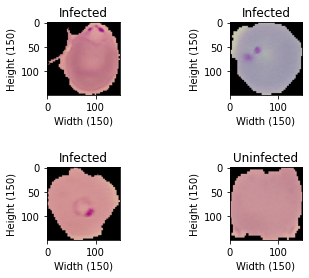

In [14]:
# get list of 4 random number within len(df)
indexes = random.sample(range(len(df)), 4)
show_samples(df.iloc[indexes].values)

### Splitting the Data

We will split the data into training and validation. 

In [15]:
df_trn = df.iloc[:int(len(df) * 0.8)]
df_val = df.iloc[int(len(df) * 0.8):]

### Data Loader

Now that the data is ready, we can use create a DataLoader that will be used for training.

In [16]:
class MalariaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.n_samples = len(dataframe)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image, label = self.dataframe.iloc[index]
        if self.transform: 
            image = self.transform(image)
        return image, label

In [17]:
train_dataset = MalariaDataset(df_trn, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

Let's check that the data loader is working properly:

Batch 0
torch.Size([4, 3, 150, 150])


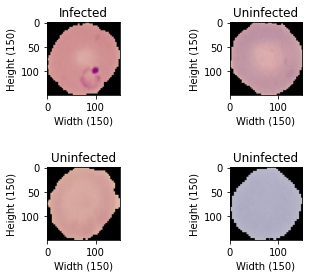

Batch 1
torch.Size([4, 3, 150, 150])


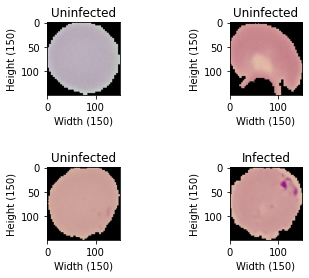

Batch 2
torch.Size([4, 3, 150, 150])


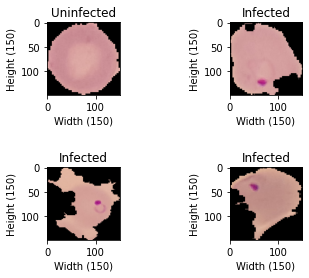

In [ ]:
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}")
    print(images.shape)
    show_samples([[np.transpose(image.numpy(),(2, 1, 0)), label] for (image, label) in zip(images, labels)])
    if i == 2: 
        break

# Model Architecture

The model architecture is as follows:
* CNN model with FC layers
* Convolutional 3x3 layers
* Maxpool 2x2
* Fully connected layers
* Activation function: ReLU

### Defining the Model

We use the nn.Module class to define the model.

In [18]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_size): 
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(output_channels, hidden_size, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_size, hidden_size, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(18496, 300),
            nn.ReLU(),
            nn.Linear(300, 100), 
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x): 
        output = self.conv_layers(x)
        output = output.view(output.size()[0], -1)
        output = self.fc_layers(output)
        return output

In [19]:
model = CNN(3, 6, 64)

loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Check that the model architecture is correct:

In [ ]:
for i, (images, labels) in enumerate(train_loader):
    # ensure labels are same size and type
    labels = labels.unsqueeze(1).float()
    outputs = model(images)
    loss_value = loss(outputs, labels)
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()
    break

## Training the Model



In [20]:
num_epochs = 1
learning_rate = 0.001
num_steps = len(train_loader)
print(num_steps)

5512


In [21]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        # ensure labels are same size and type
        labels = labels.unsqueeze(1).float()
        # forward pass
        outputs = model(images)
        loss_value = loss(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        # print loss
        if i % 500 == 0: 
            print(f"Epoch {epoch+1}/{num_epochs}, Step {i}/{num_steps}, Loss: {loss_value.item():.4f}")

Epoch 1/1, Step 0/5512, Loss: 0.6740
Epoch 1/1, Step 500/5512, Loss: 0.5089
Epoch 1/1, Step 1000/5512, Loss: 0.6036
Epoch 1/1, Step 1500/5512, Loss: 0.4464
Epoch 1/1, Step 2000/5512, Loss: 0.6278
Epoch 1/1, Step 2500/5512, Loss: 0.0253
Epoch 1/1, Step 3000/5512, Loss: 0.6948
Epoch 1/1, Step 3500/5512, Loss: 0.0178
Epoch 1/1, Step 4000/5512, Loss: 0.0204
Epoch 1/1, Step 4500/5512, Loss: 0.0766
Epoch 1/1, Step 5000/5512, Loss: 0.4357
Epoch 1/1, Step 5500/5512, Loss: 0.0440


## Evaluating the Model

We can now test the model on the validation set.

In [22]:
val_dataset = MalariaDataset(df_val, transform=transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [23]:
accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predictions = torch.max(outputs, axis=1)
        accuracy += (predictions == labels).sum().item()

    accuracy /= len(val_dataset)
    print(f"Validation accuracy: {accuracy:.4f}")


Validation accuracy: 0.5000
